In [1]:
import pandas as pd
from biom import load_table
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
sns.set_style('ticks')

In [2]:
data = pd.read_csv('../data/mice/Group_d_6_11_months_MA.csv', index_col=0)

In [3]:
table = data.iloc[:, 1:]
metadata = data.iloc[:, 0]

In [4]:
table = table.loc[:, table.sum(axis=0)>0]

In [5]:
from sklearn.cross_decomposition import PLSRegression
from skbio.stats.composition import clr, centralize, multiplicative_replacement
ctable = pd.DataFrame(clr(centralize(table+1)),
                      index=table.index, columns=table.columns)

rfc = PLSRegression(n_components=2)
rfc.fit(X=ctable.values, Y=metadata=='d, 6 month')

PLSRegression(copy=True, max_iter=500, n_components=2, scale=True, tol=1e-06)

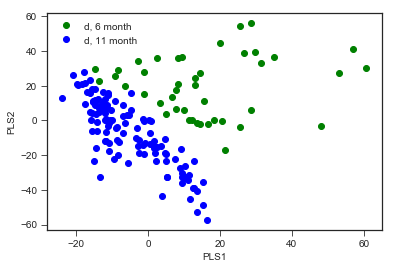

In [6]:
group1 = 'd, 6 month'
group2 = 'd, 11 month'

midx = metadata=='d, 6 month'
lidx = metadata=='d, 11 month'
plt.plot(rfc.x_scores_[midx, 0], rfc.x_scores_[midx, 1], 'og', label=group1)
plt.plot(rfc.x_scores_[lidx, 0], rfc.x_scores_[lidx, 1], 'ob', label=group2)
plt.xlabel('PLS1')
plt.ylabel('PLS2')
plt.legend()

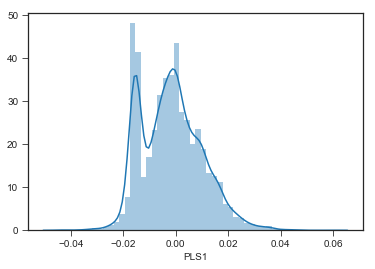

In [7]:
rfc = PLSRegression(n_components=1)
rfc.fit(X=ctable.values, Y=metadata=='d, 6 month')
pls_df = pd.DataFrame(rfc.x_weights_, index=ctable.columns, columns=['PLS1'])
sns.distplot(pls_df.PLS1)

In [8]:
from sklearn.mixture import GaussianMixture
gmod = GaussianMixture(n_components=3, 
                       means_init=[[-0.02], [0], [0.02]])
gmod = GaussianMixture(n_components=3)
gmod.fit(X=pls_df.values)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

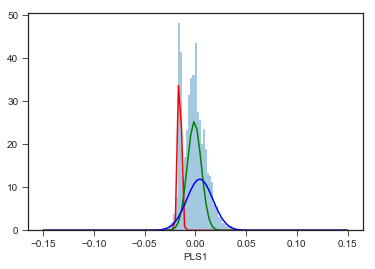

In [9]:
from scipy.stats import norm

m = np.ravel(gmod.means_)
s = np.ravel(np.sqrt(gmod.covariances_)) 
w = np.ravel(gmod.weights_)

x = np.linspace(-0.15, 0.15, 100)
sns.distplot(pls_df.PLS1, norm_hist=True, kde=False)
plt.plot(x, w[0]*norm.pdf(x, m[0], s[0]), '-r')
plt.plot(x, w[1]*norm.pdf(x, m[1], s[1]), '-g')
plt.plot(x, w[2]*norm.pdf(x, m[2], s[2]), '-b')

In [10]:
from pls_balances.src.balances import round_balance
l, r = round_balance(pls_df.values)

In [11]:
denom = pls_df.loc[pls_df.PLS1 < l]
num = pls_df.loc[pls_df.PLS1 > r]

In [12]:
pls_balance = (np.log(table.loc[:, num.index] + 1).mean(axis=1) - 
               np.log(table.loc[:, denom.index] + 1).mean(axis=1))

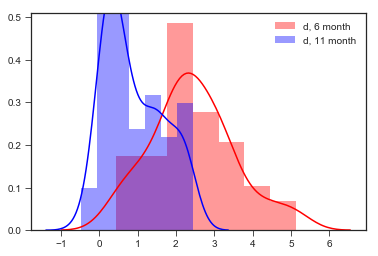

In [13]:
sns.distplot(pls_balance[metadata==group1], label=group1, color='r', bins=7)
sns.distplot(pls_balance[metadata==group2], label=group2, color='b', bins=7)
plt.legend()

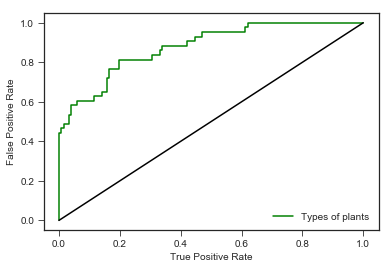

In [14]:
from sklearn.metrics import roc_curve
group_var = metadata == 'd, 6 month'
group_fpr, group_tpr, plant_thresholds = roc_curve(y_true=1-group_var.astype(int), 
                                                   y_score=pls_balance)

plt.plot(group_tpr, group_fpr, label='Types of plants', c='green')
plt.plot(np.linspace(0, 1), np.linspace(0, 1), c='k')
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.legend(loc=4)
plt.savefig('group_roc_curves.pdf')

In [15]:
from sklearn.metrics import auc
print('Group AUC:\t', auc(group_tpr, group_fpr))

Group AUC:	 0.878339419566


In [16]:
from scipy.stats import f_oneway
group_f, group_p = f_oneway(pls_balance.loc[metadata=='d, 6 month'],
                            pls_balance.loc[metadata=='d, 11 month'])

print('Types of plants\t -- F-statistic: %f \t p-value: \t %E' % (group_f, group_p))

Types of plants	 -- F-statistic: 102.172443 	 p-value: 	 6.259128E-19


In [17]:
num

,PLS1
131.9741_892.9921,0.012844
182.9852_892.0618,0.016489
98.5121_892.7961,0.014337
99.5298_886.2538,0.008563
185.0183_886.4596,0.006269
100.5102_880.4829,0.010697
155.9744_898.2838,0.011180
274.2743_342.7520,0.009188
143.9622_882.3764,0.008449
318.3006_400.6059,0.010605


In [18]:
denom

,PLS1
125.9860_887.1478,-0.013674
186.9810_883.6267,-0.028783
159.9691_894.0801,-0.018924
167.0130_886.6285,-0.019180
162.0055_886.8795,-0.022677
97.0270_886.3588,-0.021840
143.9940_886.8922,-0.013089
88.0214_886.5560,-0.027314
110.0195_892.3338,-0.027850
107.5172_892.4377,-0.036911


In [19]:
table.shape

(164, 7412)